#Weather Prediction System using Bayesian Networks
Assignment Objective: Predict weather conditions based on past data points

Made by:
- EL YOUSFI-ALAOUI Mohammed
- El Ajjouri Safaa
- Tlemcani chayma
- Motassim ahmed taha

In [63]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\tmmot\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore


# Step 1: Importing Data
-Loading the Weather Dataset, containing hourly weather forecasting.

-Discrete and continuous variables include precipitation type, temperature, humidity, wind speed, and more


In [99]:
df = pd.read_csv('weatherHistory.csv')
#df.set_index("Formatted Date", inplace=True)
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [100]:
df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')

# Step 2: Data Cleaning
-Ensuring data integrity by removing missing values (NAs)

-Analyzing relationships between variables by calculating the correlation matrix

-Aggregating data for better analysis and model training

-Discretizing continuous values to transform them into categorical variables

In [104]:
# Convert the 'Formatted Date' column to datetime format
# The format argument specifies the current format of the dates in the column
# The errors argument is set to 'coerce' to handle any errors during conversion by setting them to NaT (Not a Time)
# The utc argument is set to True to convert the datetime to UTC
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], format="%Y-%m-%d %H:%M:%S.%f %z", errors='coerce', utc=True)

# Extract the date part from the 'Formatted Date' column
df['Formatted Date'] = df['Formatted Date'].dt.date

# Convert the 'Formatted Date' column back to datetime format
# This is done because the previous operation converted the column to object type
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-03-31,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [105]:
print(df['Formatted Date'].dtype)

datetime64[ns]


In [106]:
df['Daily Summary'].describe()

count                                 96453
unique                                  214
top       Mostly cloudy throughout the day.
freq                                  20085
Name: Daily Summary, dtype: object

In [107]:
df['Precip Type'].value_counts()

Precip Type
rain    85224
snow    10712
Name: count, dtype: int64

In [108]:
# Pre-processing

# Check for missing values (NaNs) in the dataframe 'df'
# The isnull() function returns a dataframe of True/False values indicating whether each value is missing or not
# The sum() function then sums these boolean values, giving the total number of missing values in each column
print(df.isnull().sum())

# Print the total number of rows in the dataframe 'df'
print(len(df))

# Remove rows with missing values in the 'Precip Type' column
# The dropna() function is used with the subset argument to specify the column to check for missing values
# The inplace argument is set to True to modify the original dataframe 'df' directly
df.dropna(subset=['Precip Type'], inplace=True)

print("\n")
# Check for missing values (NaNs) in the dataframe 'df' again, after removing rows with missing 'Precip Type'
print(df.isnull().sum())

# Print the total number of rows in the dataframe 'df' after removing rows with missing 'Precip Type'
print(len(df))
df.head()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64
96453


Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64
95936


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-03-31,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [109]:
# Remove the 'Summary' column from the dataframe 'df'
# The drop() function is used with the axis argument set to 1 to specify that a column (not a row) is being dropped
# The inplace argument is set to True to modify the original dataframe 'df' directly
df.drop('Summary' , axis = 1 , inplace = True)

In [110]:
#Check loud Cover
df['Loud Cover'].describe()

count    95936.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Loud Cover, dtype: float64

In [111]:
# The output shows that all values in the 'Loud Cover' column are 0.0, which means this column provides no useful information

# Remove the 'Loud Cover' column from the dataframe 'df'
# The drop() function is used with the axis argument set to 1 to specify that a column (not a row) is being dropped
# The inplace argument is set to True to modify the original dataframe 'df' directly
df.drop('Loud Cover' , axis = 1 , inplace = True)

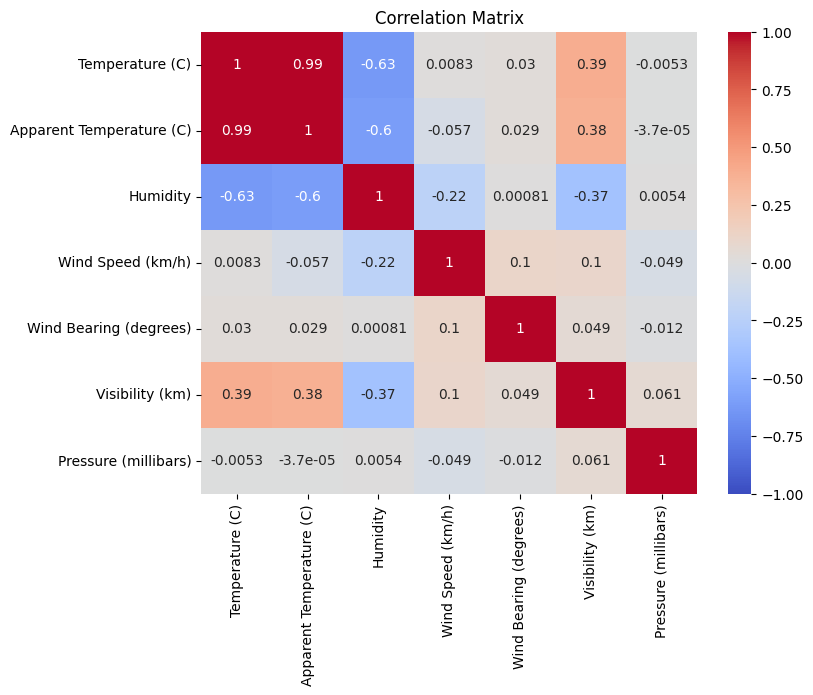

In [75]:
# Calculate the correlation matrix of the dataframe 'df'
# The corr() function calculates the pairwise correlation of columns, excluding NA/null values
# The numeric_only argument is set to True to include only numeric columns in the correlation calculation

correlation_matrix = df.corr(numeric_only=True)

# Create a heatmap to visualize the correlation matrix
# The figure size is set to 8x6 inches
plt.figure(figsize=(8, 6))

# The heatmap() function from seaborn is used to plot the correlation matrix
# The annot argument is set to True to write the data value in each cell
# The cmap argument is set to 'coolwarm' to use the coolwarm colormap
# The vmin and vmax arguments are set to -1 and 1 respectively to anchor the colormap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Set the title of the heatmap
plt.title('Correlation Matrix')

# Display the plot
plt.show()

In [112]:
#Temperature is ~~ Temperature apparente so we gonna drop the Apparente Temperature
df.drop('Apparent Temperature (C)' , axis = 1 , inplace = True)

In [114]:
# Aggregating the data

# Group the dataframe 'df' by 'Formatted Date' and aggregate the other columns
# The groupby() function is used to group the dataframe by 'Formatted Date'
# The agg() function is used to apply different aggregation functions to different columns
# 'first' is used for 'Daily Summary' and 'Precip Type' to get the first value in each group
# 'mean' is used for the numeric columns to get the average value in each group
grouped = df.groupby(df['Formatted Date']).agg(
    {'Daily Summary': 'first',
     'Precip Type': 'first',
     'Temperature (C)': 'mean',
     'Humidity': 'mean',
     'Wind Speed (km/h)' : 'mean',
     'Wind Bearing (degrees)' : 'mean',
     'Visibility (km)' : 'mean',
     'Pressure (millibars)' : 'mean'
     })

# The result is a new DataFrame with the 'Formatted Date' column and aggregated values for the specified columns.

# Display the first 24 rows of the aggregated dataframe
grouped.head(24)

,Daily Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Formatted Date,,,,,,,,
2005-12-31,Mostly cloudy throughout the day.,rain,0.577778,0.890000,17.114300,140.000000,9.982000,1016.660000
2006-01-01,Mostly cloudy throughout the day.,rain,4.075000,0.817083,21.229192,142.750000,11.348487,1011.985000
2006-01-02,Overcast throughout the day.,rain,5.263194,0.847083,17.824713,164.583333,8.492079,1010.384167
2006-01-03,Mostly cloudy throughout the day.,rain,2.340509,0.897083,7.726658,252.541667,9.223958,1021.170833
2006-01-04,Overcast throughout the day.,rain,2.251852,0.906667,12.152817,35.000000,8.352546,981.770833
2006-01-05,Foggy in the morning.,rain,2.703935,0.951250,8.991179,139.875000,4.308092,935.873750
2006-01-06,Foggy until morning.,rain,2.550463,0.945833,5.729588,269.500000,4.635458,1023.645833
2006-01-07,Foggy starting overnight continuing until morn...,rain,0.877083,0.935833,6.589596,102.041667,4.585817,1030.223750
2006-01-08,Partly cloudy in the afternoon.,snow,-1.231713,0.868750,5.397525,113.916667,8.694671,1035.481250


In [115]:
len(grouped['Daily Summary'])

4009

In [116]:
# Calculate the percentage of each 'Daily Summary' value in the original DataFrame
percentage_per_summary = grouped['Daily Summary'].value_counts() / len(grouped)

# Create a mask to filter rows where the percentage is greater than 1%
mask = grouped['Daily Summary'].apply(lambda x: percentage_per_summary.get(x, 0)) > 0.01

# Apply the mask to the grouped DataFrame
filtered_grouped = grouped[mask]

In [118]:
# Discretization of continuous values

# Discretize the 'Temperature (C)' column into 5 equal-sized bins
# The cut() function is used to bin values into discrete intervals
# The labels argument is used to specify the labels for the resulting bins
temp = pd.cut(filtered_grouped['Temperature (C)'], 5, labels=["Very low", "Low", "Medium", "High", "Very high"])

# Repeat the same process for the 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', and 'Pressure (millibars)' columns
humidity = pd.cut(filtered_grouped['Humidity'], 5, labels=["Very low", "Low", "Medium", "High", "Very high"])
wind_speed = pd.cut(filtered_grouped['Wind Speed (km/h)'], 5, labels=["Very low", "Low", "Medium", "High", "Very high"])
wind_bearing = pd.cut(filtered_grouped['Wind Bearing (degrees)'], 5, labels=["Very low", "Low", "Medium", "High", "Very high"])
visibility = pd.cut(filtered_grouped['Visibility (km)'], 5, labels=["Very low", "Low", "Medium", "High", "Very high"])
pressure = pd.cut(filtered_grouped['Pressure (millibars)'], 5, labels=["Very low", "Low", "Medium", "High", "Very high"])

# Get the column names of the dataframe 'filtered_grouped'
columns_names = filtered_grouped.columns

# Display the column names
columns_names

Index(['Daily Summary', 'Precip Type', 'Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)'],
      dtype='object')

In [119]:
# Create a dictionary where the keys are the column names and the values are the corresponding Series
# The first two columns are taken directly from the 'filtered_grouped' dataframe
# The remaining columns are the discretized versions created in the previous step
d = { columns_names[0]: filtered_grouped[columns_names[0]],
     columns_names[1]: filtered_grouped[columns_names[1]],
     columns_names[2]: temp,
     columns_names[3]: humidity,
     columns_names[4]: wind_speed,
     columns_names[5]: wind_bearing,
     columns_names[6]: visibility,
     columns_names[7]: pressure,
    }

# Create a new dataframe 'new_df' from the dictionary 'd'
# The DataFrame() constructor is used to convert the dictionary into a dataframe
new_df = pd.DataFrame(data=d)

# Display the new dataframe
new_df

,Daily Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Formatted Date,,,,,,,,
2005-12-31,Mostly cloudy throughout the day.,rain,Low,Very high,High,Medium,High,Very high
2006-01-01,Mostly cloudy throughout the day.,rain,Medium,High,Very high,Medium,High,Very high
2006-01-02,Overcast throughout the day.,rain,Medium,High,High,Medium,Medium,Very high
2006-01-03,Mostly cloudy throughout the day.,rain,Low,Very high,Low,High,Medium,Very high
2006-01-04,Overcast throughout the day.,rain,Low,Very high,Medium,Very low,Medium,Very high
...,...,...,...,...,...,...,...,...
2016-12-27,Mostly cloudy throughout the day.,snow,Low,Very high,Medium,Medium,Medium,Very high
2016-12-28,Mostly cloudy throughout the day.,snow,Low,Very high,Medium,Medium,Medium,Very high
2016-12-29,Mostly cloudy throughout the day.,snow,Low,Very high,Medium,Medium,Medium,Very high
